# Share notebook edited by Daniel

### CV Theory

#### What is YOLO?


YOLO stands for You Only Look Once. It is a real-time object recognition algorithm. It can classify and localize multiple objects in a single frame. YOLO is a very fast and accurate algorithm for its simpler network architecture.

#### How does YOLO work?

YOLO works using mainly these techniques.

1. Residual Blocks – Basically, it divides an image into NxN grids.

2. Bounding Box regression – Each grid cell is sent to the model. Then YOLO determines the probability of the cell contains a certain class and the class with the maximum probability is chosen.

3. Intersection Over Union (IOU) – IOU is a metric that evaluates intersection between the predicted bounding box and the ground truth bounding box. A Non-max suppression technique is applied to eliminate the bounding boxes that are very close by performing the IoU with the one having the highest class probability among them.

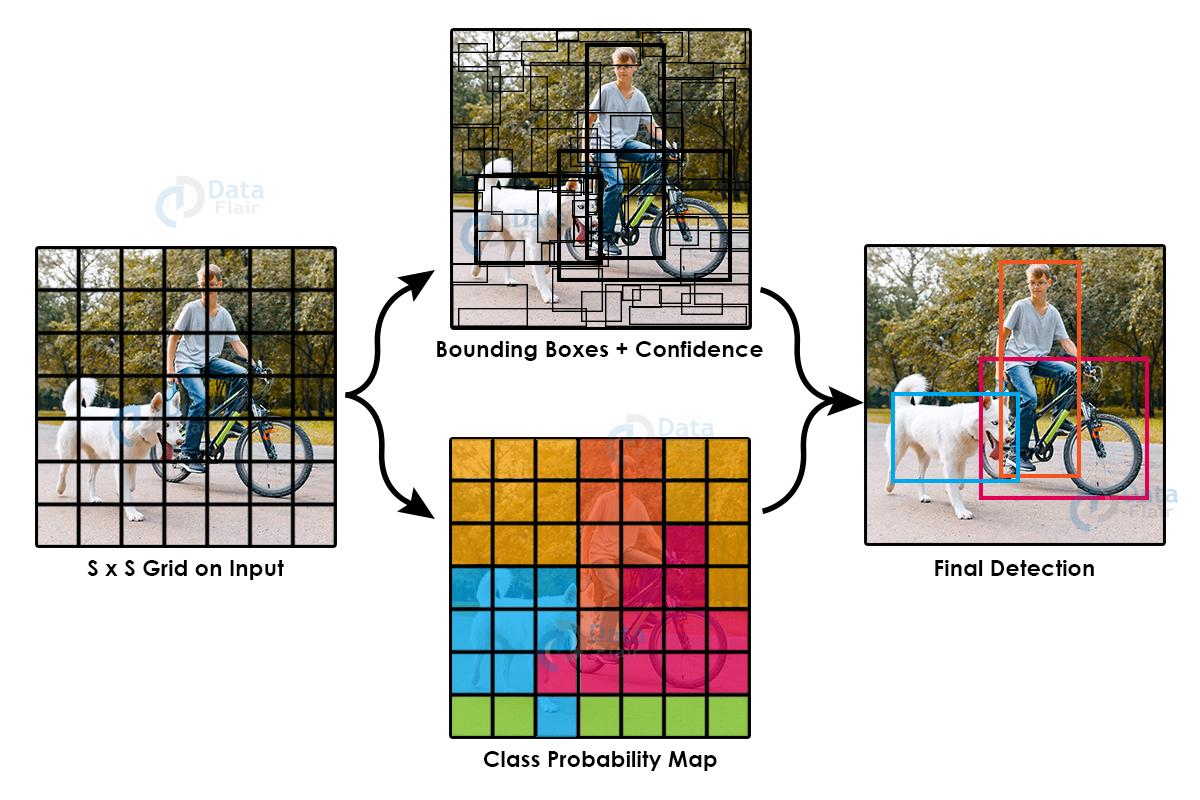

### 0. Import libraries

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
warnings.filterwarnings("ignore")

### 1. Data Load

In [4]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

path_annotrain = "../datasets/datasets_train/train_annotation/_annotation.csv"

path_image = "../datasets/datasets_train/train/"

train_annotation = pd.read_csv(path_annotrain, index_col=0)

bbox_train_full = train_annotation.loc[
    :, ["im_name", "x_min", "y_min", "x_max", "y_max"]
]




def load_plot(im_name, x1, y1, x2, y2):

    im = np.asanyarray(Image.open(f"../datasets/datasets_train/train/{im_name}"))

    # Display the image
    plt.imshow(im)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"
    )

    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()


#### 1.1 Check annotations

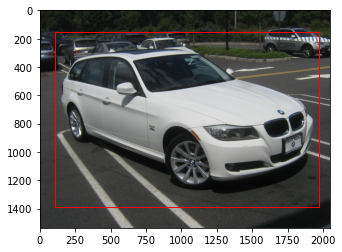

In [5]:
im_test = bbox_train_full.iloc[111, 0]
x1, y1, x2, y2 = bbox_train_full.loc[bbox_train_full["im_name"] == im_test].iloc[0, 1:]

load_plot(im_test, x1, y1, x2, y2)

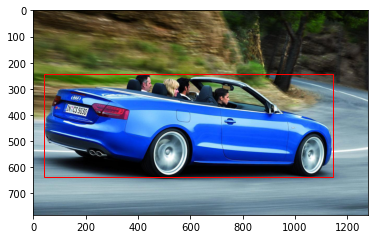

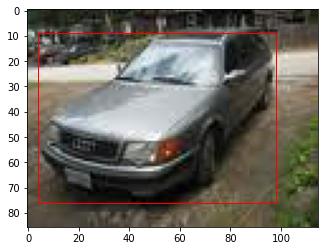

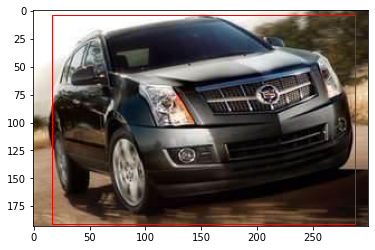

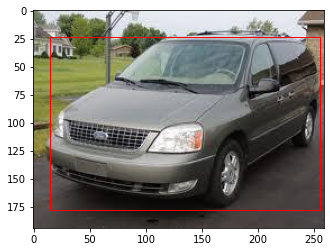

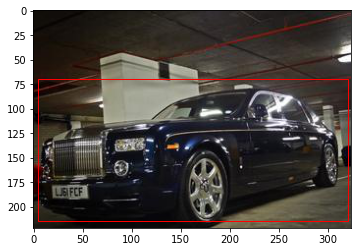

In [6]:
for i in range(5):
    im_test = bbox_train_full.iloc[i, 0]
    x1, y1, x2, y2 = bbox_train_full.loc[bbox_train_full["im_name"] == im_test].iloc[0, 1:]

    load_plot(im_test, x1, y1, x2, y2)
    

#### 1.2 Visualizing Data

In [7]:
train_annotation.head()

,im_name,x_min,y_min,x_max,y_max,class,models
0,107347968.jpg,40.0,244.0,1144.0,637.0,car,Audi S5 Convertible 2012
1,91160576.jpg,4.0,9.0,98.0,76.0,car,Audi 100 Wagon 1994
2,273809408.jpg,16.0,4.0,288.0,191.0,car,Cadillac SRX SUV 2012
3,579534848.jpg,14.0,23.0,255.0,178.0,car,Ford Freestar Minivan 2007
4,950599680.jpg,4.0,70.0,321.0,215.0,car,Rolls-Royce Phantom Sedan 2012


In [8]:
train_annotation.shape

(2641, 7)

### 2. Selective Search

In [9]:
cv2.setUseOptimized(True) # Optimize
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Selective search object

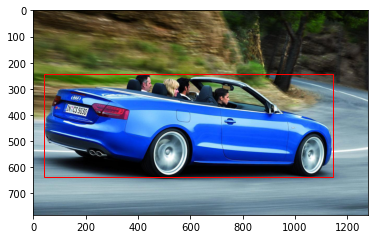

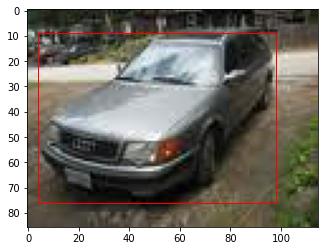

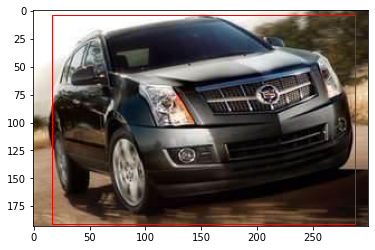

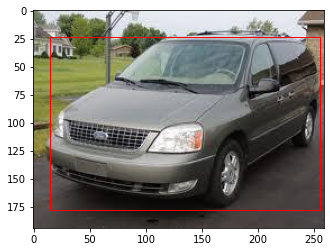

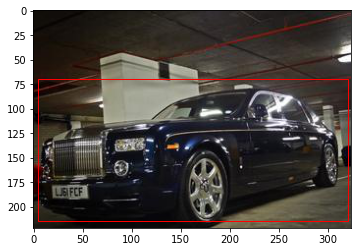

In [10]:
for i in range(5):
    im_test = bbox_train_full.iloc[i, 0]
    x1, y1, x2, y2 = bbox_train_full.loc[bbox_train_full["im_name"] == im_test].iloc[0, 1:]

    load_plot(im_test, x1, y1, x2, y2)
    

Shape: (224, 224, 3)
possible bounty boxes: 678


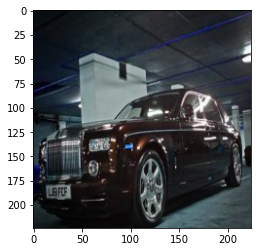

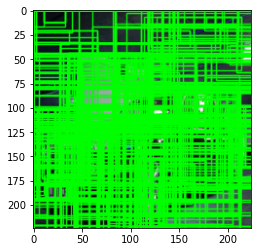

In [11]:
im = cv2.imread(f"../datasets/datasets_train/train/{im_test}")
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) # GÖrüntünün yüklendiği kısım
ss.switchToSelectiveSearchFast() # Selective Search süresini hızlandırmak için
rects = ss.process()
print('Shape:',im.shape)
print('possible bounty boxes:',len(rects))

for rect in rects:
  x, y, w, h = rect
  imOut=cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

#### 2.1 Selective serach crop the image iou>0.5

In [12]:
#Iou and selective search 
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
image_liste=[]
k=0
l=0
z=0 #Loading
images_with_bbox = pd.read_csv(path_annotrain)
images_with_bbox.dropna(inplace=True)
for a in images_with_bbox.values:
    image_index, im_name,xmin,ymin,xmax,ymax,object_class,car_model=a
    bb1={ #real bounding boxes
        'x1':int(xmin),
        'y1':int(ymin),
        'x2':int(xmax),
        'y2':int(ymax)
        }
    try:
        img=cv2.imread(path_image+im_name)
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        for i in rects:
            x, y, w, h = i # Selective bounty boxxes
            bb2={'x1':x, 
              'y1':y,
              'x2':x+w,
              'y2':y+h
              }
            img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] # Crop img
            img1_shape=cv2.resize(img1,(224,224))
            if k<l:
                if 0.5<get_iou(bb1,bb2):  
                    image_liste.append([img1_shape,1])
                    k+=1
            else:
                if 0.5<get_iou(bb1,bb2):  
                    image_liste.append([img1_shape,1])
                    k+=1
                else:
                    image_liste.append([img1_shape,0])
                    l+=1
    except Exception as e:
        print('error var',e)
    z+=1
    print(im_name,z,len(rects))

107347968.jpg 1 5047
91160576.jpg 2 152
273809408.jpg 3 893
579534848.jpg 4 609
950599680.jpg 5 928
73465856.jpg 6 1294
136052736.jpg 7 2929
421593088.jpg 8 11811
93716480.jpg 9 792
490930176.jpg 10 1279
834732032.jpg 11 7250
597426176.jpg 12 6608
65470464.jpg 13 768
46268416.jpg 14 6685
622592000.jpg 15 520
512163840.jpg 16 888
772800512.jpg 17 2272
40894464.jpg 18 437
370475008.jpg 19 611
54591488.jpg 20 1150
93061120.jpg 21 152
433455104.jpg 22 1516
720568320.jpg 23 3837
863174656.jpg 24 698
17498112.jpg 25 2315
370868224.jpg 26 795
946995200.jpg 27 2847
568524800.jpg 28 1499
836763648.jpg 29 7129
551223296.jpg 30 4202
274530304.jpg 31 893
764870656.jpg 32 1333
357367808.jpg 33 1934
875495424.jpg 34 7196
795410432.jpg 35 3128
384499712.jpg 36 2186
899022848.jpg 37 4268
392364032.jpg 38 3890
596180992.jpg 39 602
172032000.jpg 40 2126
142082048.jpg 41 2528
296681472.jpg 42 1833
902103040.jpg 43 2260
554696704.jpg 44 927
66387968.jpg 45 730
596967424.jpg 46 4573
547094528.jpg 47 1903
7

In [ ]:
len(image_liste)

In [14]:
data=[]
data_label=[]
for features,label in image_liste:
    data.append(features)
    data_label.append(label)
print('success')

success


In [15]:
print('number photos:',len(data),'number labels:',len(data_label))

number photos: 110006 number labels: 110006


Class: 1
Image Size: (224, 224, 3)


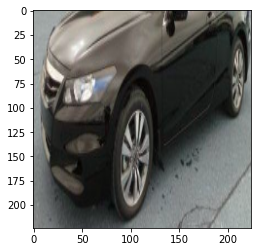

In [16]:
i=random.randint(1,10583)
print('Class:',data_label[i])
print('Image Size:',data[i].shape)
plt.imshow(data[i]);

In [17]:
data=np.asarray(data)
data_label=np.asarray(data_label) 

In [18]:
print('Not a car image:',len(data_label[data_label==0]),'Car image:',len(data_label[data_label==1]))

Not a car image: 55001 Car image: 55005


In [19]:
data.shape

(110006, 224, 224, 3)

In [20]:
data_label.shape

(110006,)

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data,data_label,test_size=0.33, random_state=42)

In [ ]:
print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

### 3. Model

In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

In [ ]:
base_model.summary()

In [ ]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
base_model.trainable=False

In [ ]:
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,'-',layer.trainable)

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

In [ ]:
epoch=4
hist=model.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

### 5.Test

In [ ]:
im_test = bbox_train_full.iloc[i, 0]
    x1, y1, x2, y2 = bbox_train_full.loc[bbox_train_full["im_name"] == im_test].iloc[0, 1:]

In [ ]:
car=[]
photo_path='../input/car-object-detection/data/testing_images/vid_5_27620.jpg'
test_img=cv2.imread(photo_path)
ss.setBaseImage(test_img)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()
print('Number of possible objects in the photo: ',len(rects1))
for i in rects1:
    x, y, w, h = i
    bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }
    try:
        assert bb3['x1'] < bb3['x2']
        assert bb3['y1'] < bb3['y2']
        img_data=test_img[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
        img_data=cv2.resize(img_data,(224,224))
        prediction=model.predict(img_data.reshape(1,224,224,3))
        if prediction[0]>0.5:
            car.append([bb3,prediction[0]])
        else:
            pass
    except Exception as e:
    print('error',e)
print('how many possible bounty boxes with a class test of 1 are there:',len(car))
print('-------------------------------------------------------------------------')
test_img=cv2.imread(photo_path)
car[np.argmax(np.array(car)[:,1])][0]
pt1=(car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2=(car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(test_img)
cv2.rectangle(test_img,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'Class number is 1 and bounty box score has the highest probability.: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}') 
plt.imshow(test_img);